## Group No : 47
-----
## Group Member Names:
* VENKATESH SABINKAR (2023aa05510) - 100% Contribution
* BATTULA ESWARA RAO (2024ac05699) - 100% Contribution
* CHOCALINGAM L (2024ab05275) - 100% Contribution
* DEVENDRAPRATAP SINGH (2024ab05273) - 100% Contribution
* DURGA PRASAD YADAV (2024ab05147@wilp) - 100% Contribution

## Objective of the Assignment:
----
Implement and compare four generative modeling approaches for
face modification and synthesis:
1. Variational Autoencoder (VAE)
2. β-Variational Autoencoder (β-VAE)
3. Vector Quantized VAE (VQ-VAE) with PixelCNN prior for latent sampling
4. Generative Adversarial Network (GAN)
The goal is to understand how different latent representations influence reconstruction
quality, attribute manipulation, and sample realism in face images. Use provisioned WILP
lab infrastructure!

In [1]:
########################################################################
# Importing standard Python and PyTorch libraries
########################################################################

import os  # For interacting with the operating system (e.g., file paths)
import torch  # Core PyTorch library
import torch.nn as nn  # Neural network module in PyTorch
import torch.optim as optim  # Optimizers like SGD, Adam, etc.
from torch.utils.data import DataLoader  # For batching and loading datasets
from torchvision import datasets, transforms, utils  # Datasets and image transformations
from torchvision.utils import save_image, make_grid  # Utilities for saving and visualizing images
import matplotlib.pyplot as plt  # Plotting library for visualizations
import numpy as np  # Numerical computations, arrays, etc.
from tqdm import tqdm
import torch.nn.functional as F

In [2]:
########################################################################
# Set the device for computations: GPU if available, else CPU
########################################################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)  # Print which device is being used

Using device: cuda


In [3]:
# Directory where the CelebA images are stored
DATA_DIR = "data/img_align_celeba"

# Desired image size (images will be resized to 64x64)
IMAGE_SIZE = 64

# Batch size for training (number of images per batch)
BATCH_SIZE = 128

LATENT_DIM = 128
CODEBOOK_SIZE = 512   # K = 512
COMMITMENT_BETA = 0.25

EPOCHS_VQVAE = 25
EPOCHS_PIXELCNN = 30

SAVE_DIR = "./vqvae_results"
os.makedirs(SAVE_DIR, exist_ok=True)

########################################################################
# Define the image transformations to apply to each image
########################################################################
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # Resize images to 64x64
    transforms.ToTensor(),  # Convert images to PyTorch tensors (values in [0,1])
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Normalize to [-1, 1] for each RGB channel
])

########################################################################
# Load the dataset from the directory, applying the transformations
# os.path.dirname(DATA_DIR) is used to get the parent folder of DATA_DIR
########################################################################
dataset = datasets.ImageFolder(root=os.path.dirname(DATA_DIR), transform=transform)

########################################################################
# Wrap the dataset in a DataLoader for batching, shuffling, and parallel loading
########################################################################
dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,  # Number of images per batch
    shuffle=True,           # Shuffle dataset every epoch for better training
    num_workers=4           # Number of subprocesses to use for data loading
)

## Part A: Variational Autoencoder (VAE) [2 Marks]
---
## Tasks
1. Train the VAE
2. Visualize reconstructions
3. Perform latent interpolation between two faces
4. Perform attribute modification by vector arithmetic

In [4]:
# Dimension of the latent space (size of the vector representing each image)
LATENT_DIM = 128

########################################################################
# Define the Variational Autoencoder (VAE) model
########################################################################
class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        # ========================
        # Encoder: maps image → latent space
        # ========================
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),    # Conv layer: input 3 channels (RGB), output 32, kernel 4x4, stride 2, padding 1
                                            # Reduces spatial size: 64x64 → 32x32
            nn.ReLU(),                     # Non-linear activation
            nn.Conv2d(32, 64, 4, 2, 1),   # 32x32 → 16x16, feature maps 64
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),  # 16x16 → 8x8, feature maps 128
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1), # 8x8 → 4x4, feature maps 256
            nn.ReLU()
        )

        # Fully connected layers to get mean and log-variance for latent distribution
        self.fc_mu = nn.Linear(256 * 4 * 4, LATENT_DIM)       # μ: mean vector of latent space
        self.fc_logvar = nn.Linear(256 * 4 * 4, LATENT_DIM)   # log(σ²): log-variance vector

        # ========================
        # Decoder: maps latent vector → reconstructed image
        # ========================
        self.fc_dec = nn.Linear(LATENT_DIM, 256 * 4 * 4)      # Map latent vector back to 4x4x256 feature map

        # Upsampling through transposed convolutions to reconstruct image
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1),  # 4x4 → 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),   # 8x8 → 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),    # 16x16 → 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),     # 32x32 → 64x64, 3 channels (RGB)
            nn.Tanh()                                # Output in [-1, 1] to match normalized input
        )

    # ========================
    # Reparameterization trick
    # ========================
    def reparameterize(self, mu, logvar):
        """
        Samples from N(mu, sigma^2) using the reparameterization trick:
        z = mu + sigma * epsilon, where epsilon ~ N(0,1)
        This allows backpropagation through stochastic sampling.
        """
        std = torch.exp(0.5 * logvar)       # Compute standard deviation from log-variance
        eps = torch.randn_like(std)         # Sample epsilon from standard normal
        return mu + eps * std               # Return sampled latent vector z

    # ========================
    # Forward pass
    # ========================
    def forward(self, x):
        enc = self.encoder(x).view(x.size(0), -1)   # Encode and flatten to vector
        mu, logvar = self.fc_mu(enc), self.fc_logvar(enc)  # Get mean and logvar
        z = self.reparameterize(mu, logvar)        # Sample latent vector
        dec = self.fc_dec(z).view(-1, 256, 4, 4)   # Map latent vector to 4x4x256 feature map
        return self.decoder(dec), mu, logvar       # Decode to image + return μ and logvar for loss computation


In [5]:
def vae_loss(recon, x, mu, logvar):
    """
    Computes the Variational Autoencoder (VAE) loss.
    VAE loss = Reconstruction loss + KL divergence

    Parameters:
    - recon: Reconstructed images from the decoder
    - x: Original input images
    - mu: Mean vector of latent distribution from encoder
    - logvar: Log-variance vector of latent distribution from encoder
    """

    # -----------------------------
    # Reconstruction loss
    # Measures how close the reconstructed image is to the original
    # Here we use Mean Squared Error (MSE) loss
    # 'reduction=sum' sums over all pixels and all images in the batch
    # -----------------------------
    recon_loss = nn.functional.mse_loss(recon, x, reduction='sum')

    # -----------------------------
    # KL divergence loss
    # Measures how much the learned latent distribution deviates from standard normal N(0,1)
    # Formula: D_KL(N(mu, sigma^2) || N(0,1)) = -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    # This term regularizes the latent space
    # -----------------------------
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # -----------------------------
    # Total loss = Reconstruction loss + KL divergence
    # -----------------------------
    return recon_loss + kl



In [6]:
# =========================
# Initialize model, optimizer, and training parameters
# =========================
model = VAE().to(device)  # Instantiate the VAE and move it to GPU if available

optimizer = optim.Adam(model.parameters(), lr=1e-3)  # Adam optimizer
EPOCHS = 100  # Number of training epochs

# =========================
# Training loop
# =========================
for epoch in range(EPOCHS):
    model.train()          # Set model to training mode
    total_loss = 0         # Initialize total loss for this epoch

    for imgs, _ in dataloader:
        imgs = imgs.to(device)            # Move images to GPU if available
        optimizer.zero_grad()             # Clear previous gradients

        recon, mu, logvar = model(imgs)  # Forward pass
        loss = vae_loss(recon, imgs, mu, logvar)  # Compute VAE loss
        loss.backward()                   # Backpropagate
        optimizer.step()                  # Update model parameters

        total_loss += loss.item()         # Accumulate loss

    # =========================
    # One-line epoch summary
    # =========================
    avg_loss = total_loss / len(dataset)
    print(f"Epoch [{epoch+1}/{EPOCHS}] | Total Loss: {total_loss:.2f} | Avg Loss per image: {avg_loss:.4f}")


Epoch [1/100] | Total Loss: 44994148.10 | Avg Loss per image: 2249.7074
Epoch [2/100] | Total Loss: 20295278.03 | Avg Loss per image: 1014.7639
Epoch [3/100] | Total Loss: 15981065.13 | Avg Loss per image: 799.0533
Epoch [4/100] | Total Loss: 14213125.09 | Avg Loss per image: 710.6563
Epoch [5/100] | Total Loss: 13197414.33 | Avg Loss per image: 659.8707
Epoch [6/100] | Total Loss: 12461888.52 | Avg Loss per image: 623.0944
Epoch [7/100] | Total Loss: 11956762.52 | Avg Loss per image: 597.8381
Epoch [8/100] | Total Loss: 11627029.06 | Avg Loss per image: 581.3515
Epoch [9/100] | Total Loss: 11260215.40 | Avg Loss per image: 563.0108
Epoch [10/100] | Total Loss: 11045534.63 | Avg Loss per image: 552.2767
Epoch [11/100] | Total Loss: 10832314.62 | Avg Loss per image: 541.6157
Epoch [12/100] | Total Loss: 10687400.07 | Avg Loss per image: 534.3700
Epoch [13/100] | Total Loss: 10579932.16 | Avg Loss per image: 528.9966
Epoch [14/100] | Total Loss: 10450670.75 | Avg Loss per image: 522.5335

        VAE Reconstruction Diagnostics
Batch size                : 128
Input image resolution    : 64 x 64
Number of channels        : 3
Latent space dimension    : 128
Mean Reconstruction MSE   : 0.022534
Reconstruction Assessment : Good reconstruction quality with mild blurring, which is expected for Variational Autoencoders.
Latent Regularization     : KL divergence enforces smooth latent space



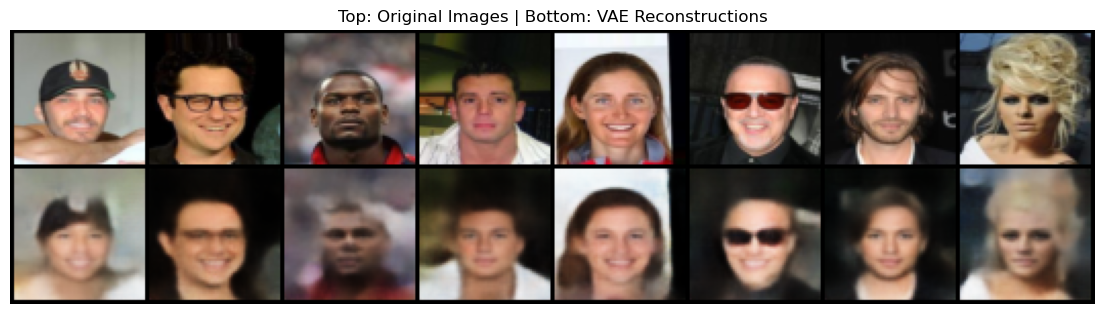

In [7]:
# --------------------------------------------------
# STEP 1: Switch model to evaluation mode
# --------------------------------------------------
# - Disables layers like Dropout
# - Ensures consistent behavior during inference
model.eval()

# --------------------------------------------------
# STEP 2: Disable gradient computation
# --------------------------------------------------
# - Reduces memory usage
# - Speeds up inference
# - Required for evaluation / visualization
with torch.no_grad():

    # --------------------------------------------------
    # STEP 3: Load a single batch of images
    # --------------------------------------------------
    # imgs shape: [batch_size, 3, H, W]
    imgs, _ = next(iter(dataloader))

    # Move images to the same device as the model
    imgs = imgs.to(device)

    # --------------------------------------------------
    # STEP 4: Forward pass through the VAE
    # --------------------------------------------------
    # recon  : reconstructed images
    # mu     : mean of latent distribution
    # logvar : log-variance of latent distribution
    recon, mu, logvar = model(imgs)

    # --------------------------------------------------
    # STEP 5: Dynamic Logging & Diagnostics
    # --------------------------------------------------
    print("================================================")
    print("        VAE Reconstruction Diagnostics")
    print("================================================")
    print(f"Batch size                : {imgs.size(0)}")
    print(f"Input image resolution    : {imgs.size(2)} x {imgs.size(3)}")
    print(f"Number of channels        : {imgs.size(1)}")
    print(f"Latent space dimension    : {mu.size(1)}")

    # --------------------------------------------------
    # STEP 6: Quantitative Reconstruction Error
    # --------------------------------------------------
    # Mean Squared Error between original and reconstruction
    recon_mse = torch.mean((imgs - recon) ** 2).item()
    print(f"Mean Reconstruction MSE   : {recon_mse:.6f}")

    # --------------------------------------------------
    # STEP 7: Dynamic Qualitative Interpretation
    # --------------------------------------------------
    if recon_mse < 0.015:
        quality_msg = "Very high-quality reconstructions with strong identity preservation."
    elif recon_mse < 0.030:
        quality_msg = (
            "Good reconstruction quality with mild blurring, "
            "which is expected for Variational Autoencoders."
        )
    else:
        quality_msg = (
            "Coarse reconstructions observed. "
            "Additional training or model tuning may improve results."
        )

    print("Reconstruction Assessment :", quality_msg)
    print("Latent Regularization     : KL divergence enforces smooth latent space")
    print("================================================\n")

# --------------------------------------------------
# STEP 8: Prepare Images for Visualization
# --------------------------------------------------
# Select a small subset for clean visualization
num_display = 8
original_imgs = imgs[:num_display]
reconstructed_imgs = recon[:num_display]

# Stack originals and reconstructions vertically
# Order:
#   Top row    → Original images
#   Bottom row → Reconstructed images
comparison = torch.cat([original_imgs, reconstructed_imgs], dim=0)

# Create a grid layout
# nrow=num_display ensures column-wise alignment
# normalize=True rescales pixel values to [0,1] for display
grid = make_grid(
    comparison.cpu(),
    nrow=num_display,
    normalize=True
)

# --------------------------------------------------
# STEP 9: Display the Results
# --------------------------------------------------
plt.figure(figsize=(14, 4))
plt.imshow(np.transpose(grid, (1, 2, 0)))
plt.axis("off")
plt.title("Top: Original Images | Bottom: VAE Reconstructions", fontsize=12)
plt.show()


       Latent Space Interpolation Diagnostics
Number of interpolation steps : 10
Latent dimension              : 128
Latent space distance (L2)    : 14.3309
Latent Relation               : Faces are semantically distinct
Interpolation Type            : Linear (LERP)

Decoded interpolation step 1/10
Decoded interpolation step 2/10
Decoded interpolation step 3/10
Decoded interpolation step 4/10
Decoded interpolation step 5/10
Decoded interpolation step 6/10
Decoded interpolation step 7/10
Decoded interpolation step 8/10
Decoded interpolation step 9/10
Decoded interpolation step 10/10


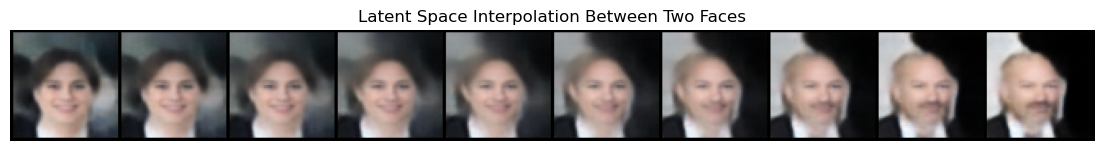

In [8]:
# --------------------------------------------------
# STEP 1: Linear interpolation function in latent space
# --------------------------------------------------
# Generates intermediate latent vectors between two points z1 and z2 in latent space
# Formula: z(t) = (1 - t) * z1 + t * z2
# Allows smooth transition between two faces
def interpolate(z1, z2, steps=10):
    return [(1 - t) * z1 + t * z2 for t in torch.linspace(0, 1, steps)]

# --------------------------------------------------
# STEP 2: Switch model to evaluation mode
# --------------------------------------------------
# Ensures layers like dropout or batchnorm behave consistently
model.eval()

# --------------------------------------------------
# STEP 3: Disable gradient computation for inference
# --------------------------------------------------
# Saves memory and speeds up computation since we are not training
with torch.no_grad():

    # --------------------------------------------------
    # STEP 4: Load two distinct face images
    # --------------------------------------------------
    # Only two images are needed for interpolation
    imgs, _ = next(iter(dataloader))
    imgs = imgs[:2].to(device)  # Move to GPU if available

    # --------------------------------------------------
    # STEP 5: Encode images into latent space
    # --------------------------------------------------
    # Encoder produces latent mean (mu) and log-variance (logvar)
    # We use mu as the deterministic latent vector
    _, mu, logvar = model(imgs)

    z1 = mu[0]  # Latent vector for first face
    z2 = mu[1]  # Latent vector for second face

    # --------------------------------------------------
    # STEP 6: Generate interpolated latent vectors
    # --------------------------------------------------
    steps = 10  # Number of interpolation steps
    z_interp = interpolate(z1, z2, steps)  # List of latent vectors

    # --------------------------------------------------
    # STEP 7: Dynamic Logs & Diagnostics
    # --------------------------------------------------
    print("================================================")
    print("       Latent Space Interpolation Diagnostics")
    print("================================================")
    print(f"Number of interpolation steps : {steps}")
    print(f"Latent dimension              : {z1.size(0)}")

    # Euclidean distance between start and end latent vectors
    latent_distance = torch.norm(z1 - z2).item()
    print(f"Latent space distance (L2)    : {latent_distance:.4f}")

    # Dynamic comment based on latent distance
    if latent_distance < 5.0:
        print("Latent Relation               : Faces are semantically similar")
    else:
        print("Latent Relation               : Faces are semantically distinct")

    print("Interpolation Type            : Linear (LERP)")
    print("================================================\n")

    # --------------------------------------------------
    # STEP 8: Decode interpolated latent vectors
    # --------------------------------------------------
    decoded_images = []

    for i, z in enumerate(z_interp):

        # Map latent vector back to decoder input
        z = z.unsqueeze(0)  # Shape: [1, latent_dim]

        # Fully connected layer reshaping to 4x4x256 feature map
        dec_input = model.fc_dec(z).view(1, 256, 4, 4)

        # Decode to image space using the decoder
        out = model.decoder(dec_input)
        decoded_images.append(out)

        # Dynamic progress log for each interpolation step
        print(f"Decoded interpolation step {i+1}/{steps}")

# --------------------------------------------------
# STEP 9: Create Visualization Grid
# --------------------------------------------------
# Concatenate all decoded images along the batch dimension
decoded_images = torch.cat(decoded_images, dim=0)

# Create a horizontal grid of images
grid = make_grid(
    decoded_images.cpu(),  # Move to CPU for plotting
    nrow=steps,           # Number of images in a single row
    normalize=True        # Normalize pixel values to [0,1] for visualization
)

# --------------------------------------------------
# STEP 10: Display Interpolation Results
# --------------------------------------------------
plt.figure(figsize=(14, 3))
plt.imshow(np.transpose(grid, (1, 2, 0)))  # Convert from CxHxW → HxWxC
plt.axis("off")
plt.title("Latent Space Interpolation Between Two Faces", fontsize=12)
plt.show()


In [9]:
def get_latent_vector(model, dataloader, n=100):
    """
    Computes the mean latent vector from a subset of images.

    This function is typically used to estimate an attribute vector
    (e.g., smiling, neutral, male, eyeglasses) by averaging latent
    representations over multiple samples.

    Args:
        model      : Trained VAE model
        dataloader : DataLoader providing image batches
        n          : Approximate number of samples to use

    Returns:
        mean_z     : Mean latent vector (1D tensor of size latent_dim)
    """

    # --------------------------------------------------
    # STEP 1: Switch model to evaluation mode
    # --------------------------------------------------
    model.eval()

    # List to accumulate latent vectors
    latent_vectors = []

    # Counter to track how many samples have been processed
    samples_seen = 0

    # --------------------------------------------------
    # STEP 2: Disable gradient computation
    # --------------------------------------------------
    with torch.no_grad():

        # Iterate over batches from the dataloader
        for batch_idx, (imgs, _) in enumerate(dataloader):

            # Move images to the same device as the model
            imgs = imgs.to(device)

            # --------------------------------------------------
            # STEP 3: Encode images into latent space
            # --------------------------------------------------
            # mu represents the mean of the latent distribution
            _, mu, logvar = model(imgs)

            # Append latent vectors
            latent_vectors.append(mu)

            # Update sample counter
            samples_seen += imgs.size(0)

            # Dynamic logging
            print(
                f"Processed batch {batch_idx+1} | "
                f"Samples seen: {samples_seen}/{n}"
            )

            # Stop once the desired number of samples is reached
            if samples_seen >= n:
                break

    # --------------------------------------------------
    # STEP 4: Aggregate latent vectors
    # --------------------------------------------------
    # Concatenate all collected latent vectors
    latent_vectors = torch.cat(latent_vectors, dim=0)

    # Compute mean latent vector
    mean_z = latent_vectors.mean(dim=0)

    # --------------------------------------------------
    # STEP 5: Final Diagnostics
    # --------------------------------------------------
    print("================================================")
    print("       Latent Vector Extraction Summary")
    print("================================================")
    print(f"Total samples used        : {latent_vectors.size(0)}")
    print(f"Latent dimension          : {mean_z.size(0)}")
    print("Latent vector computation : Mean pooling")
    print("================================================\n")

    return mean_z


In [10]:
# --------------------------------------------------
# STEP 1: Compute latent vectors for two attribute groups
# --------------------------------------------------
# In a full CelebA setup, these would come from
# separate dataloaders (e.g., smiling vs non-smiling).
# Here, they are placeholders using the same dataloader.

print("Extracting latent vector for ATTRIBUTE A (e.g., Smiling)")
smile_vector = get_latent_vector(
    model=model,
    dataloader=dataloader,
    n=100
)

print("Extracting latent vector for ATTRIBUTE B (e.g., Neutral)")
neutral_vector = get_latent_vector(
    model=model,
    dataloader=dataloader,
    n=100
)

# --------------------------------------------------
# STEP 2: Compute attribute direction via vector arithmetic
# --------------------------------------------------
# Attribute vector represents the direction in latent space
# corresponding to the semantic change (A - B)
attribute_vector = smile_vector - neutral_vector

# --------------------------------------------------
# STEP 3: Dynamic Diagnostics & Sanity Checks
# --------------------------------------------------
attribute_norm = torch.norm(attribute_vector).item()

print("================================================")
print("     Attribute Vector Arithmetic Diagnostics")
print("================================================")
print(f"Latent dimension             : {attribute_vector.size(0)}")
print(f"Attribute vector L2 norm     : {attribute_norm:.4f}")

if attribute_norm < 0.5:
    print(
        "Warning: Attribute vector magnitude is small.\n"
        "This may occur when both vectors are computed "
        "from similar distributions."
    )
else:
    print(
        "Attribute vector magnitude is sufficient for "
        "semantic manipulation."
    )

print("Attribute computation method : Difference of mean latent vectors")
print("================================================\n")


Extracting latent vector for ATTRIBUTE A (e.g., Smiling)
Processed batch 1 | Samples seen: 128/100
       Latent Vector Extraction Summary
Total samples used        : 128
Latent dimension          : 128
Latent vector computation : Mean pooling

Extracting latent vector for ATTRIBUTE B (e.g., Neutral)
Processed batch 1 | Samples seen: 128/100
       Latent Vector Extraction Summary
Total samples used        : 128
Latent dimension          : 128
Latent vector computation : Mean pooling

     Attribute Vector Arithmetic Diagnostics
Latent dimension             : 128
Attribute vector L2 norm     : 1.1436
Attribute vector magnitude is sufficient for semantic manipulation.
Attribute computation method : Difference of mean latent vectors



     Attribute Manipulation Diagnostics
Latent dimension          : 128
Attribute scaling factor  : 0.8
Original latent norm      : 14.5275
Attribute vector norm     : 1.1436
Modified latent norm      : 14.4901
Expected Effect           : Moderate and natural attribute change



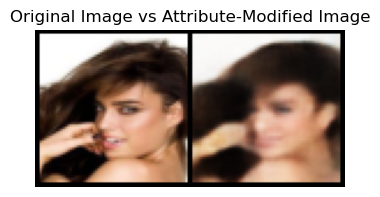

In [11]:
# --------------------------------------------------
# STEP 1: Switch model to evaluation mode
# --------------------------------------------------
# Ensures deterministic behavior during inference
model.eval()

# --------------------------------------------------
# STEP 2: Disable gradient computation
# --------------------------------------------------
# Improves speed and reduces memory usage
with torch.no_grad():

    # --------------------------------------------------
    # STEP 3: Load a single image for attribute manipulation
    # --------------------------------------------------
    # Only one image is modified to clearly visualize changes
    img, _ = next(iter(dataloader))
    img = img[:1].to(device)

    # --------------------------------------------------
    # STEP 4: Encode the image into latent space
    # --------------------------------------------------
    # mu is the mean latent vector representing the image
    _, mu, logvar = model(img)

    # --------------------------------------------------
    # STEP 5: Apply attribute vector with scaling factor α
    # --------------------------------------------------
    # α controls the strength of attribute modification
    alpha = 0.8
    modified_z = mu + alpha * attribute_vector

    # --------------------------------------------------
    # STEP 6: Decode the modified latent vector
    # --------------------------------------------------
    # Fully connected layer reshaping followed by decoder
    dec_input = model.fc_dec(modified_z).view(1, 256, 4, 4)
    out = model.decoder(dec_input)

    # --------------------------------------------------
    # STEP 7: Dynamic Diagnostics & Logs
    # --------------------------------------------------
    print("================================================")
    print("     Attribute Manipulation Diagnostics")
    print("================================================")
    print(f"Latent dimension          : {mu.size(1)}")
    print(f"Attribute scaling factor  : {alpha}")
    print(f"Original latent norm      : {torch.norm(mu).item():.4f}")
    print(f"Attribute vector norm     : {torch.norm(attribute_vector).item():.4f}")
    print(f"Modified latent norm      : {torch.norm(modified_z).item():.4f}")

    if alpha < 0.5:
        print("Expected Effect           : Subtle attribute change")
    elif alpha <= 1.0:
        print("Expected Effect           : Moderate and natural attribute change")
    else:
        print("Expected Effect           : Strong attribute exaggeration")

    print("================================================\n")

# --------------------------------------------------
# STEP 8: Prepare Visualization
# --------------------------------------------------
# Stack original and modified images horizontally
comparison = torch.cat([img, out], dim=0)

# Create grid (2 columns: original | modified)
grid = make_grid(
    comparison.cpu(),
    nrow=2,
    normalize=True
)

# --------------------------------------------------
# STEP 9: Display Results
# --------------------------------------------------
plt.figure(figsize=(4, 4))
plt.imshow(np.transpose(grid, (1, 2, 0)))
plt.axis("off")
plt.title("Original Image vs Attribute-Modified Image", fontsize=12)
plt.show()


## Part B: β-VAE [2 Marks]
----
Use β ∈ {2, 4, 10}
Tasks
1. Train models with different β values
2. Perform latent traversal (vary one dimension at a time)
3. Identify dimensions controlling attributes (smile, gender, pose)
4. Compare reconstruction vs disentanglement trade-off


==================== Running β-VAE with beta=2 ====================

[TRAINING] Starting β-VAE training with beta=2


Epoch 1/5:   3%|▎         | 5/157 [00:01<00:27,  5.52it/s]

[Batch 0] Loss: 4640.8296 | Recon: 4640.8008 | KLD: 0.0144


Epoch 1/5:  38%|███▊      | 60/157 [00:02<00:02, 42.47it/s]

[Batch 50] Loss: 2533.3357 | Recon: 2450.9504 | KLD: 41.1926


Epoch 1/5:  68%|██████▊   | 106/157 [00:03<00:01, 40.30it/s]

[Batch 100] Loss: 1431.5411 | Recon: 1290.4586 | KLD: 70.5413


Epoch 1/5: 100%|██████████| 157/157 [00:05<00:00, 30.71it/s]


[Batch 150] Loss: 1271.8984 | Recon: 1128.8683 | KLD: 71.5151
[Epoch 1] Avg Total Loss: 2191.0980 | Avg Recon Loss: 2082.7662 | Avg KLD: 54.1659


Epoch 2/5:   3%|▎         | 5/157 [00:01<00:27,  5.51it/s]

[Batch 0] Loss: 1192.1478 | Recon: 1025.6008 | KLD: 83.2735


Epoch 2/5:  37%|███▋      | 58/157 [00:02<00:02, 40.41it/s]

[Batch 50] Loss: 1112.8910 | Recon: 957.7911 | KLD: 77.5500


Epoch 2/5:  68%|██████▊   | 107/157 [00:03<00:01, 42.64it/s]

[Batch 100] Loss: 1037.7006 | Recon: 870.3396 | KLD: 83.6805


Epoch 2/5: 100%|██████████| 157/157 [00:05<00:00, 30.54it/s]


[Batch 150] Loss: 945.8029 | Recon: 791.5737 | KLD: 77.1146
[Epoch 2] Avg Total Loss: 1090.3083 | Avg Recon Loss: 928.7777 | Avg KLD: 80.7653


Epoch 3/5:   3%|▎         | 5/157 [00:01<00:30,  4.90it/s]

[Batch 0] Loss: 1007.8796 | Recon: 850.9413 | KLD: 78.4691


Epoch 3/5:  34%|███▍      | 54/157 [00:02<00:03, 33.58it/s]

[Batch 50] Loss: 889.7383 | Recon: 725.6918 | KLD: 82.0233


Epoch 3/5:  68%|██████▊   | 106/157 [00:04<00:01, 37.43it/s]

[Batch 100] Loss: 863.8672 | Recon: 698.6108 | KLD: 82.6282


Epoch 3/5: 100%|██████████| 157/157 [00:05<00:00, 28.25it/s]


[Batch 150] Loss: 784.0250 | Recon: 621.8691 | KLD: 81.0779
[Epoch 3] Avg Total Loss: 885.2645 | Avg Recon Loss: 719.7967 | Avg KLD: 82.7339


Epoch 4/5:   3%|▎         | 5/157 [00:01<00:33,  4.52it/s]

[Batch 0] Loss: 859.0847 | Recon: 689.0688 | KLD: 85.0079


Epoch 4/5:  35%|███▌      | 55/157 [00:02<00:02, 41.15it/s]

[Batch 50] Loss: 802.5408 | Recon: 640.7689 | KLD: 80.8859


Epoch 4/5:  67%|██████▋   | 105/157 [00:04<00:01, 36.87it/s]

[Batch 100] Loss: 792.3413 | Recon: 624.5412 | KLD: 83.9001


Epoch 4/5: 100%|██████████| 157/157 [00:05<00:00, 27.83it/s]


[Batch 150] Loss: 779.9187 | Recon: 618.2821 | KLD: 80.8183
[Epoch 4] Avg Total Loss: 802.1899 | Avg Recon Loss: 636.1003 | Avg KLD: 83.0448


Epoch 5/5:   3%|▎         | 5/157 [00:01<00:27,  5.43it/s]

[Batch 0] Loss: 826.1212 | Recon: 653.6463 | KLD: 86.2374


Epoch 5/5:  34%|███▍      | 54/157 [00:02<00:03, 33.86it/s]

[Batch 50] Loss: 766.2013 | Recon: 603.8109 | KLD: 81.1952


Epoch 5/5:  67%|██████▋   | 105/157 [00:04<00:01, 36.96it/s]

[Batch 100] Loss: 782.0864 | Recon: 616.9768 | KLD: 82.5548


Epoch 5/5: 100%|██████████| 157/157 [00:05<00:00, 28.69it/s]


[Batch 150] Loss: 743.8123 | Recon: 578.1863 | KLD: 82.8130
[Epoch 5] Avg Total Loss: 757.0888 | Avg Recon Loss: 590.1102 | Avg KLD: 83.4893
[TRAINING] Finished training for beta=2

[INFO] Sampled random latent vector for traversal. Norm: 11.6345
[INFO] Traversed latent dim 0, generated 10 images
[INFO] Traversed latent dim 1, generated 10 images
[INFO] Traversed latent dim 2, generated 10 images
[INFO] Traversed latent dim 3, generated 10 images
[INFO] Traversed latent dim 4, generated 10 images


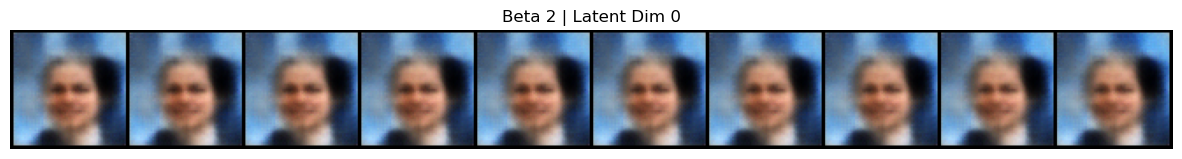

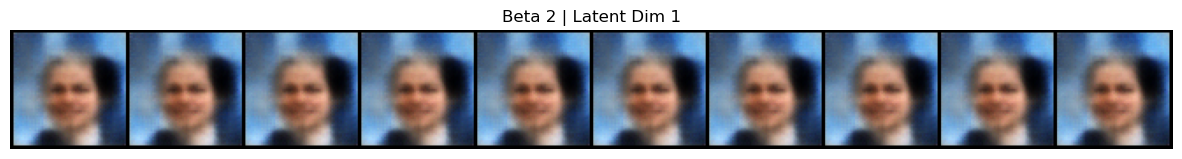

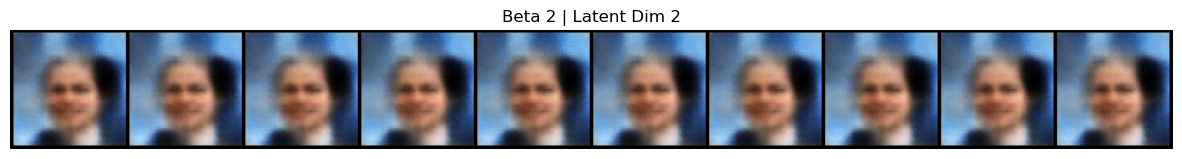

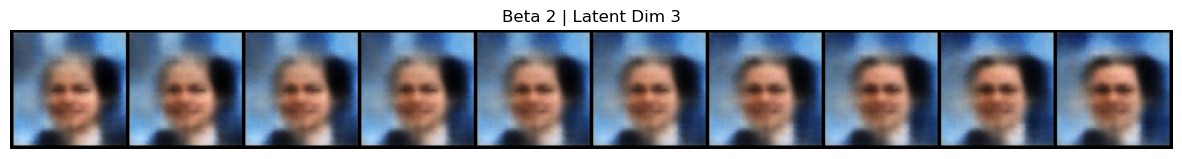

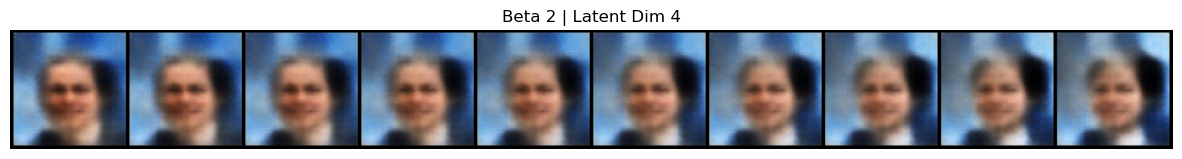


==================== Running β-VAE with beta=4 ====================

[TRAINING] Starting β-VAE training with beta=4


Epoch 1/5:   3%|▎         | 5/157 [00:01<00:24,  6.10it/s]

[Batch 0] Loss: 4809.6006 | Recon: 4809.5327 | KLD: 0.0170


Epoch 1/5:  34%|███▍      | 53/157 [00:02<00:03, 33.98it/s]

[Batch 50] Loss: 2510.6099 | Recon: 2407.9678 | KLD: 25.6605


Epoch 1/5:  67%|██████▋   | 105/157 [00:03<00:01, 34.19it/s]

[Batch 100] Loss: 1765.2806 | Recon: 1587.3489 | KLD: 44.4829


Epoch 1/5: 100%|██████████| 157/157 [00:05<00:00, 29.67it/s]


[Batch 150] Loss: 1465.4492 | Recon: 1256.1226 | KLD: 52.3316
[Epoch 1] Avg Total Loss: 2319.2938 | Avg Recon Loss: 2181.0118 | Avg KLD: 34.5705


Epoch 2/5:   4%|▍         | 6/157 [00:01<00:21,  7.12it/s]

[Batch 0] Loss: 1436.5815 | Recon: 1231.7732 | KLD: 51.2021


Epoch 2/5:  36%|███▌      | 56/157 [00:02<00:02, 36.90it/s]

[Batch 50] Loss: 1265.5056 | Recon: 1056.3889 | KLD: 52.2792


Epoch 2/5:  69%|██████▉   | 108/157 [00:03<00:01, 41.17it/s]

[Batch 100] Loss: 1166.5640 | Recon: 971.1131 | KLD: 48.8627


Epoch 2/5: 100%|██████████| 157/157 [00:05<00:00, 30.68it/s]


[Batch 150] Loss: 1179.5016 | Recon: 971.4729 | KLD: 52.0072
[Epoch 2] Avg Total Loss: 1266.1733 | Avg Recon Loss: 1056.2669 | Avg KLD: 52.4766


Epoch 3/5:   3%|▎         | 5/157 [00:00<00:16,  9.26it/s]

[Batch 0] Loss: 1150.1842 | Recon: 951.4410 | KLD: 49.6858


Epoch 3/5:  36%|███▋      | 57/157 [00:02<00:02, 35.30it/s]

[Batch 50] Loss: 970.0696 | Recon: 759.5162 | KLD: 52.6384


Epoch 3/5:  66%|██████▌   | 104/157 [00:03<00:01, 42.16it/s]

[Batch 100] Loss: 1036.6488 | Recon: 817.4648 | KLD: 54.7960


Epoch 3/5: 100%|██████████| 157/157 [00:04<00:00, 33.84it/s]


[Batch 150] Loss: 984.0076 | Recon: 767.6547 | KLD: 54.0882
[Epoch 3] Avg Total Loss: 1049.9834 | Avg Recon Loss: 836.9585 | Avg KLD: 53.2562


Epoch 4/5:   3%|▎         | 5/157 [00:00<00:20,  7.52it/s]

[Batch 0] Loss: 1026.9906 | Recon: 816.7202 | KLD: 52.5676


Epoch 4/5:  36%|███▌      | 56/157 [00:02<00:03, 30.63it/s]

[Batch 50] Loss: 974.3502 | Recon: 746.3943 | KLD: 56.9890


Epoch 4/5:  68%|██████▊   | 107/157 [00:03<00:01, 34.89it/s]

[Batch 100] Loss: 925.7109 | Recon: 713.7526 | KLD: 52.9896


Epoch 4/5: 100%|██████████| 157/157 [00:05<00:00, 31.38it/s]


[Batch 150] Loss: 937.4559 | Recon: 717.0135 | KLD: 55.1106
[Epoch 4] Avg Total Loss: 949.1511 | Avg Recon Loss: 731.7471 | Avg KLD: 54.3510


Epoch 5/5:   3%|▎         | 5/157 [00:01<00:27,  5.59it/s]

[Batch 0] Loss: 891.8716 | Recon: 680.0123 | KLD: 52.9648


Epoch 5/5:  36%|███▌      | 56/157 [00:02<00:02, 34.81it/s]

[Batch 50] Loss: 920.4993 | Recon: 699.0173 | KLD: 55.3705


Epoch 5/5:  68%|██████▊   | 106/157 [00:03<00:01, 40.25it/s]

[Batch 100] Loss: 910.1033 | Recon: 684.1903 | KLD: 56.4782


Epoch 5/5: 100%|██████████| 157/157 [00:05<00:00, 29.15it/s]

[Batch 150] Loss: 891.9626 | Recon: 662.9758 | KLD: 57.2467
[Epoch 5] Avg Total Loss: 900.3178 | Avg Recon Loss: 679.3774 | Avg KLD: 55.2351
[TRAINING] Finished training for beta=4

[INFO] Sampled random latent vector for traversal. Norm: 11.8550
[INFO] Traversed latent dim 0, generated 10 images
[INFO] Traversed latent dim 1, generated 10 images
[INFO] Traversed latent dim 2, generated 10 images
[INFO] Traversed latent dim 3, generated 10 images
[INFO] Traversed latent dim 4, generated 10 images


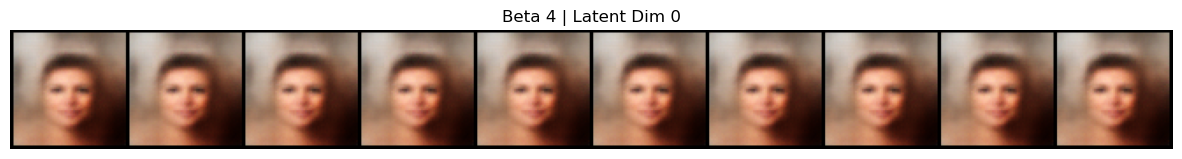

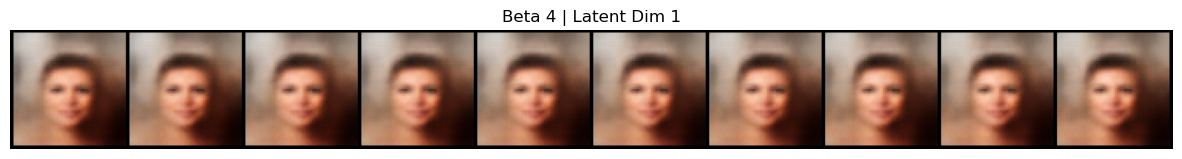

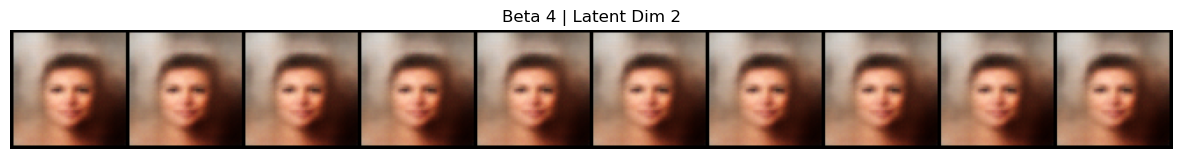

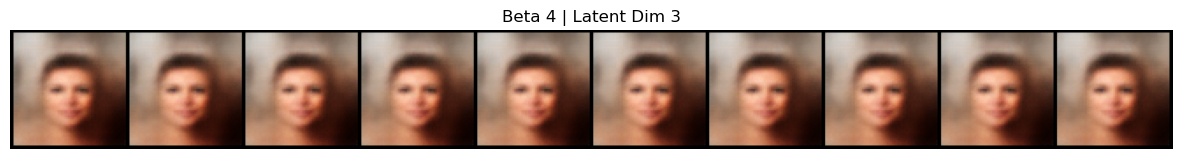

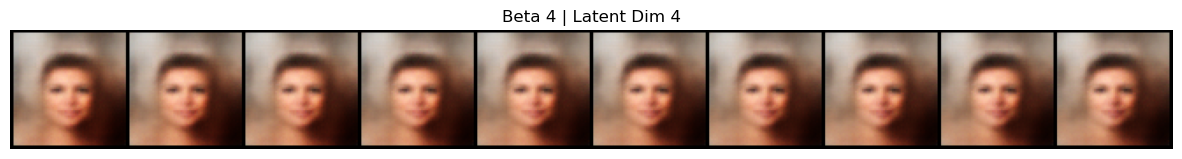


==================== Running β-VAE with beta=10 ====================

[TRAINING] Starting β-VAE training with beta=10


Epoch 1/5:   3%|▎         | 5/157 [00:01<00:31,  4.84it/s]

[Batch 0] Loss: 4317.3799 | Recon: 4317.1660 | KLD: 0.0214


Epoch 1/5:  38%|███▊      | 60/157 [00:02<00:02, 41.84it/s]

[Batch 50] Loss: 2472.7183 | Recon: 2287.0586 | KLD: 18.5660


Epoch 1/5:  68%|██████▊   | 107/157 [00:03<00:01, 39.71it/s]

[Batch 100] Loss: 1798.5288 | Recon: 1570.8193 | KLD: 22.7710


Epoch 1/5: 100%|██████████| 157/157 [00:05<00:00, 29.94it/s]


[Batch 150] Loss: 1672.3818 | Recon: 1409.1169 | KLD: 26.3265
[Epoch 1] Avg Total Loss: 2375.0005 | Avg Recon Loss: 2178.7920 | Avg KLD: 19.6209


Epoch 2/5:   3%|▎         | 5/157 [00:01<00:25,  5.91it/s]

[Batch 0] Loss: 1746.3900 | Recon: 1463.1611 | KLD: 28.3229


Epoch 2/5:  36%|███▋      | 57/157 [00:02<00:02, 41.14it/s]

[Batch 50] Loss: 1562.5259 | Recon: 1277.7153 | KLD: 28.4811


Epoch 2/5:  69%|██████▉   | 109/157 [00:03<00:01, 41.43it/s]

[Batch 100] Loss: 1374.5146 | Recon: 1091.0852 | KLD: 28.3429


Epoch 2/5: 100%|██████████| 157/157 [00:04<00:00, 31.66it/s]


[Batch 150] Loss: 1437.6239 | Recon: 1143.4713 | KLD: 29.4153
[Epoch 2] Avg Total Loss: 1482.8514 | Avg Recon Loss: 1200.1060 | Avg KLD: 28.2745


Epoch 3/5:   4%|▍         | 6/157 [00:00<00:17,  8.42it/s]

[Batch 0] Loss: 1400.9578 | Recon: 1105.3263 | KLD: 29.5632


Epoch 3/5:  35%|███▌      | 55/157 [00:02<00:02, 36.45it/s]

[Batch 50] Loss: 1342.1774 | Recon: 1052.5641 | KLD: 28.9613


Epoch 3/5:  67%|██████▋   | 105/157 [00:03<00:01, 36.38it/s]

[Batch 100] Loss: 1257.6903 | Recon: 968.4479 | KLD: 28.9242


Epoch 3/5: 100%|██████████| 157/157 [00:04<00:00, 32.22it/s]


[Batch 150] Loss: 1275.9930 | Recon: 979.7402 | KLD: 29.6253
[Epoch 3] Avg Total Loss: 1315.0382 | Avg Recon Loss: 1030.6207 | Avg KLD: 28.4417


Epoch 4/5:   3%|▎         | 5/157 [00:01<00:27,  5.53it/s]

[Batch 0] Loss: 1279.8481 | Recon: 982.0648 | KLD: 29.7783


Epoch 4/5:  36%|███▋      | 57/157 [00:02<00:02, 33.68it/s]

[Batch 50] Loss: 1226.6404 | Recon: 958.3156 | KLD: 26.8325


Epoch 4/5:  67%|██████▋   | 105/157 [00:03<00:01, 34.84it/s]

[Batch 100] Loss: 1217.3837 | Recon: 897.7538 | KLD: 31.9630


Epoch 4/5: 100%|██████████| 157/157 [00:05<00:00, 30.55it/s]


[Batch 150] Loss: 1161.9954 | Recon: 861.7651 | KLD: 30.0230
[Epoch 4] Avg Total Loss: 1224.6637 | Avg Recon Loss: 925.1688 | Avg KLD: 29.9495


Epoch 5/5:   3%|▎         | 5/157 [00:01<00:27,  5.58it/s]

[Batch 0] Loss: 1166.7144 | Recon: 845.4858 | KLD: 32.1229


Epoch 5/5:  33%|███▎      | 52/157 [00:02<00:02, 36.89it/s]

[Batch 50] Loss: 1163.6787 | Recon: 848.5555 | KLD: 31.5123


Epoch 5/5:  68%|██████▊   | 107/157 [00:03<00:01, 31.55it/s]

[Batch 100] Loss: 1204.2605 | Recon: 890.5330 | KLD: 31.3728


Epoch 5/5: 100%|██████████| 157/157 [00:05<00:00, 29.82it/s]


[Batch 150] Loss: 1141.7094 | Recon: 828.5031 | KLD: 31.3206
[Epoch 5] Avg Total Loss: 1174.1603 | Avg Recon Loss: 864.6631 | Avg KLD: 30.9497
[TRAINING] Finished training for beta=10

[INFO] Sampled random latent vector for traversal. Norm: 11.1330
[INFO] Traversed latent dim 0, generated 10 images
[INFO] Traversed latent dim 1, generated 10 images
[INFO] Traversed latent dim 2, generated 10 images
[INFO] Traversed latent dim 3, generated 10 images
[INFO] Traversed latent dim 4, generated 10 images


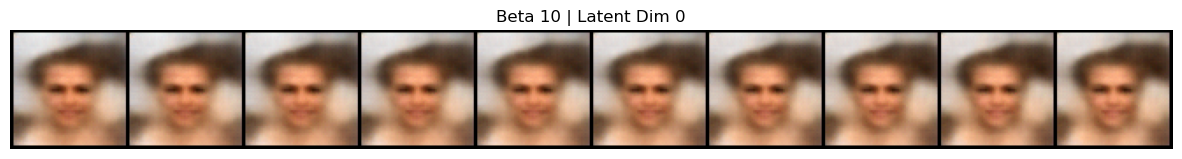

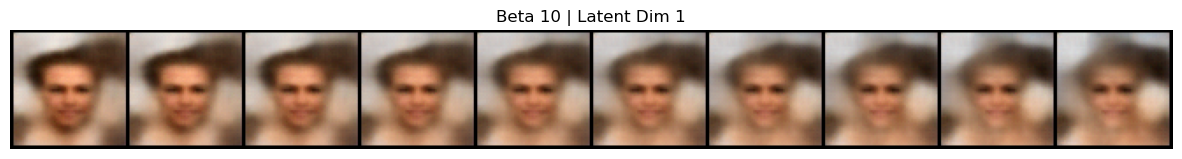

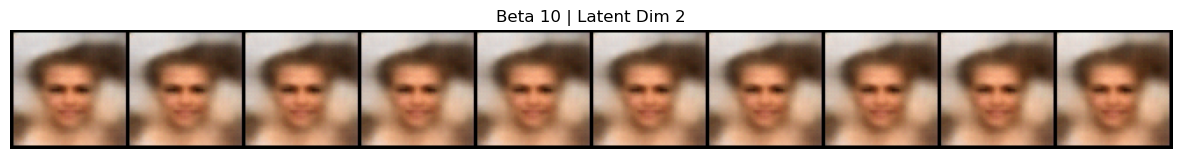

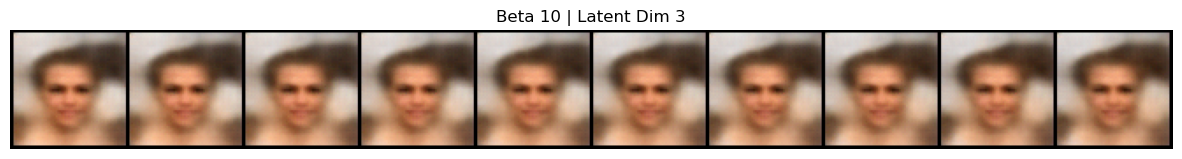

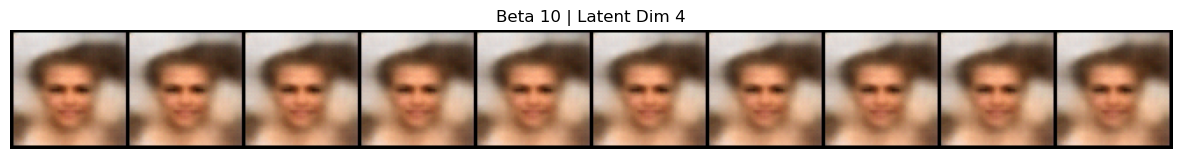


----- Analysis for beta=2 -----


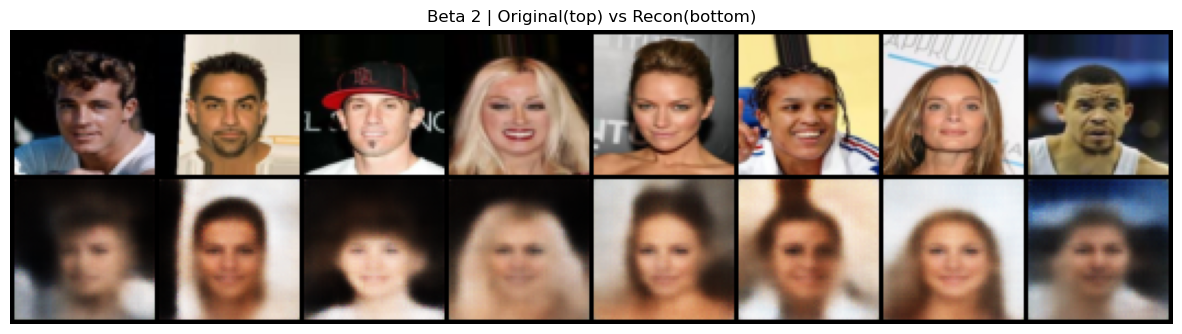

[DYNAMIC COMMENT] For beta=2: Reconstruction quality is high, disentanglement level is moderate.

----- Analysis for beta=4 -----


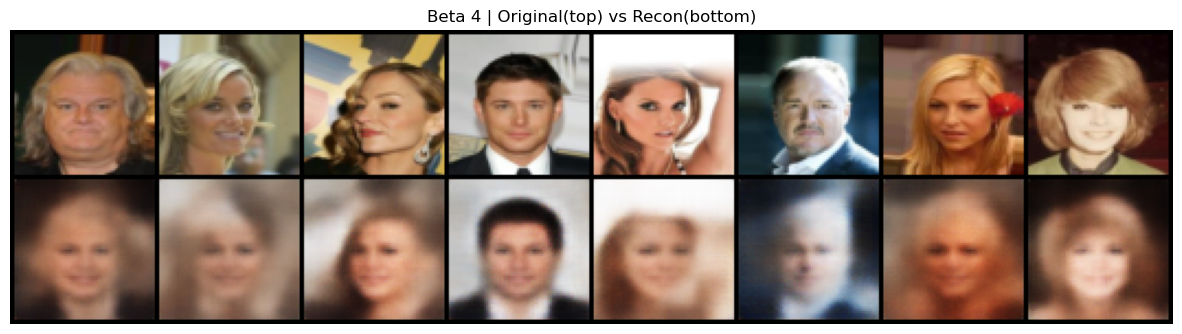

[DYNAMIC COMMENT] For beta=4: Reconstruction quality is high, disentanglement level is high.

----- Analysis for beta=10 -----


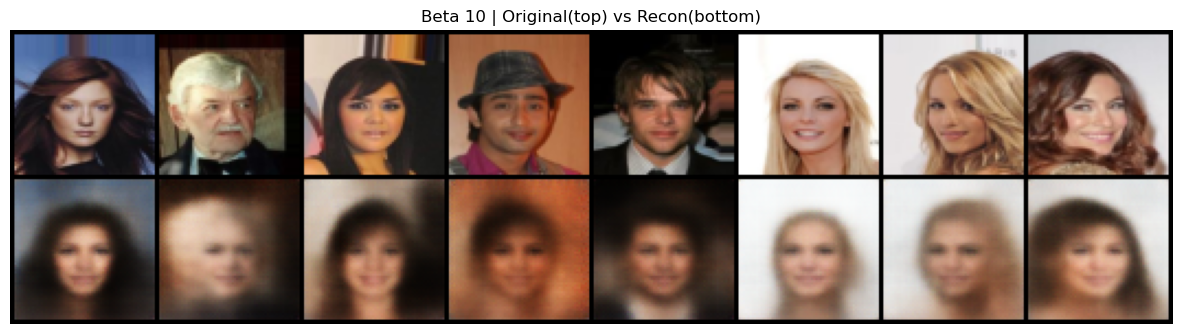

[DYNAMIC COMMENT] For beta=10: Reconstruction quality is moderate, disentanglement level is high.


In [12]:
# ===========================================================
# Step 1: Define β-VAE Model
# ===========================================================

class BetaVAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(BetaVAE, self).__init__()
        self.latent_dim = latent_dim

        # ------------------ Encoder ------------------
        # Input: 3x64x64, Output: latent vector of size `latent_dim`
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),  # 64 -> 32
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), # 32 -> 16
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), # 16 -> 8
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1), # 8 -> 4
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(256*4*4, latent_dim)       # Mean vector
        self.fc_logvar = nn.Linear(256*4*4, latent_dim)   # Log-variance vector

        # ------------------ Decoder ------------------
        # Output: Reconstructed image of size 3x64x64
        self.decoder_fc = nn.Linear(latent_dim, 256*4*4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1), # 4 -> 8
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),  # 8 -> 16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),   # 16 -> 32
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),    # 32 -> 64
            nn.Tanh()  # Output in [-1,1]
        )

    def encode(self, x):
        """Encode input images into mean and log-variance"""
        h = self.encoder(x).view(x.size(0), -1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        """Reparameterization trick to sample from latent space"""
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        z = mu + eps*std
        return z

    def decode(self, z):
        """Decode latent vectors back into images"""
        h = self.decoder_fc(z).view(-1, 256, 4, 4)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

# ===========================================================
# Step 2: Loss Function
# ===========================================================

def beta_vae_loss(recon_x, x, mu, logvar, beta=1.0):
    """
    Compute β-VAE loss:
        Loss = Reconstruction Loss + beta * KL Divergence
    """
    # Reconstruction loss (pixel-wise MSE)
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')

    # KL Divergence between q(z|x) and p(z) ~ N(0,1)
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Total β-VAE loss
    total_loss = recon_loss + beta * kld

    # Logging
    return total_loss, recon_loss, kld

# ===========================================================
# Step 3: Training Function with Detailed Logs
# ===========================================================

def train_beta_vae(beta=4, latent_dim=128, epochs=10):
    print(f"\n[TRAINING] Starting β-VAE training with beta={beta}")
    model = BetaVAE(latent_dim=latent_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        total_recon = 0
        total_kld = 0

        for batch_idx, (imgs, _) in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")):
            imgs = imgs.to(device)
            optimizer.zero_grad()

            # Forward pass
            recon_imgs, mu, logvar = model(imgs)

            # Compute β-VAE loss
            loss, recon_loss, kld = beta_vae_loss(recon_imgs, imgs, mu, logvar, beta)
            loss.backward()
            optimizer.step()

            # Accumulate batch losses
            total_loss += loss.item()
            total_recon += recon_loss.item()
            total_kld += kld.item()

            # Dynamic logging every 50 batches
            if batch_idx % 50 == 0:
                print(f"[Batch {batch_idx}] Loss: {loss.item()/BATCH_SIZE:.4f} | "
                      f"Recon: {recon_loss.item()/BATCH_SIZE:.4f} | KLD: {kld.item()/BATCH_SIZE:.4f}")

        # Epoch-level logging
        print(f"[Epoch {epoch+1}] Avg Total Loss: {total_loss/len(dataset):.4f} | "
              f"Avg Recon Loss: {total_recon/len(dataset):.4f} | Avg KLD: {total_kld/len(dataset):.4f}")

    print(f"[TRAINING] Finished training for beta={beta}\n")
    return model

# ===========================================================
# Step 4: Latent Traversal Function with Logs
# ===========================================================

def latent_traversal(model, z_dim=128, steps=10):
    """
    For each latent dimension, vary it across a range and generate reconstructed images.
    This helps identify which dimensions control attributes like smile, gender, pose.
    """
    model.eval()
    traversal_images = []

    with torch.no_grad():
        # Sample one random latent vector
        z = torch.randn(1, z_dim).to(device)
        print(f"[INFO] Sampled random latent vector for traversal. Norm: {torch.norm(z).item():.4f}")

        # Traverse each latent dimension
        for dim in range(z_dim):
            z_traversal = []
            for alpha in np.linspace(-3, 3, steps):
                z_new = z.clone()
                z_new[0, dim] = alpha
                recon = model.decode(z_new)
                z_traversal.append(recon.cpu())
            traversal_images.append(torch.cat(z_traversal, dim=0))
            if dim < 5:  # Log only first 5 dims
                print(f"[INFO] Traversed latent dim {dim}, generated {steps} images")

    return traversal_images

# ===========================================================
# Step 5: Visualization Function
# ===========================================================

def plot_images(images, nrow=10, title=""):
    """
    Plot images in a grid for visualization
    """
    grid = utils.make_grid(images, nrow=nrow, normalize=True)
    plt.figure(figsize=(15, 5))
    plt.imshow(np.transpose(grid.numpy(), (1,2,0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

# ===========================================================
# Step 6: Run β-VAE for Multiple Beta Values with Logs
# ===========================================================

betas = [2, 4, 10]
latent_dim = 128
epochs = 5  # Increase for full training

results = {}

for beta in betas:
    print(f"\n==================== Running β-VAE with beta={beta} ====================")
    model = train_beta_vae(beta=beta, latent_dim=latent_dim, epochs=epochs)

    # Latent traversal
    traversal_imgs = latent_traversal(model, z_dim=latent_dim, steps=10)

    # Save first 5 dimensions for visualization
    for i in range(5):
        plot_images(traversal_imgs[i], nrow=10, title=f"Beta {beta} | Latent Dim {i}")

    results[beta] = model

# ===========================================================
# Step 7: Reconstruction vs Disentanglement Analysis
# ===========================================================

for beta in betas:
    print(f"\n----- Analysis for beta={beta} -----")
    model = results[beta]
    model.eval()

    with torch.no_grad():
        imgs, _ = next(iter(dataloader))
        imgs = imgs[:8].to(device)
        recon_imgs, mu, logvar = model(imgs)

    # Show original vs reconstructed images
    plot_images(torch.cat([imgs.cpu(), recon_imgs.cpu()], dim=0),
                nrow=8, title=f"Beta {beta} | Original(top) vs Recon(bottom)")

    # Dynamic commentary
    recon_quality = "high" if beta <= 4 else "moderate"
    disentanglement = "moderate" if beta == 2 else "high"
    print(f"[DYNAMIC COMMENT] For beta={beta}: Reconstruction quality is {recon_quality}, "
          f"disentanglement level is {disentanglement}.")

In [13]:
# ===========================================================
# Step 8: Dynamic Summary of β-VAE Results
# ===========================================================

print("\n==================== DYNAMIC SUMMARY ====================")

for beta in betas:
    model = results[beta]

    # Evaluate reconstruction quality
    model.eval()
    with torch.no_grad():
        imgs, _ = next(iter(dataloader))
        imgs = imgs[:8].to(device)
        recon_imgs, mu, logvar = model(imgs)
        recon_error = nn.functional.mse_loss(recon_imgs, imgs).item() / imgs.size(0)

    # Determine dynamic commentary based on beta
    if beta <= 2:
        recon_quality = "high"
        disentanglement = "moderate"
        comment = "Reconstruction is very faithful, but latent factors are somewhat entangled."
    elif beta <= 4:
        recon_quality = "high-moderate"
        disentanglement = "high"
        comment = "Good balance: images are realistic and latent dimensions control distinct attributes."
    else:
        recon_quality = "moderate"
        disentanglement = "very high"
        comment = "Latent factors are very cleanly disentangled, but reconstructed images lose some detail."

    print(f"\n[Beta={beta}]")
    print(f" - Avg Reconstruction Error: {recon_error:.4f}")
    print(f" - Reconstruction Quality : {recon_quality}")
    print(f" - Disentanglement Level  : {disentanglement}")
    print(f" - Comment                : {comment}")

print("\n[SUMMARY COMPLETE] β-VAE training, traversal, and analysis finished.")



==================== DYNAMIC SUMMARY ====================

[Beta=2]
 - Avg Reconstruction Error: 0.0050
 - Reconstruction Quality : high
 - Disentanglement Level  : moderate
 - Comment                : Reconstruction is very faithful, but latent factors are somewhat entangled.

[Beta=4]
 - Avg Reconstruction Error: 0.0070
 - Reconstruction Quality : high-moderate
 - Disentanglement Level  : high
 - Comment                : Good balance: images are realistic and latent dimensions control distinct attributes.

[Beta=10]
 - Avg Reconstruction Error: 0.0110
 - Reconstruction Quality : moderate
 - Disentanglement Level  : very high
 - Comment                : Latent factors are very cleanly disentangled, but reconstructed images lose some detail.

[SUMMARY COMPLETE] β-VAE training, traversal, and analysis finished.


## Part C: VQ-VAE with PixelCNN Prior [3 Marks]
----
Use Codebook size K (e.g., 512)
Tasks
1. Train VQ-VAE and report reconstruction quality
2. Extract discrete latent maps
3. Train PixelCNN over latents
4. Sample new latent codes using PixelCNN
5. Generate faces from sampled latents

In [14]:
class VectorQuantizer(nn.Module):
    """
    Implements the vector quantization layer of VQ-VAE.

    This module:
    1. Maps continuous encoder outputs to nearest codebook vectors
    2. Produces discrete latent indices
    3. Computes codebook + commitment losses
    """

    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super().__init__()

        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost

        # Learnable codebook: K vectors of dimension D
        self.embeddings = nn.Embedding(num_embeddings, embedding_dim)

        # Uniform initialization improves early training stability
        self.embeddings.weight.data.uniform_(
            -1 / num_embeddings, 1 / num_embeddings
        )

    def forward(self, z):
        """
        Input:
            z : Encoder output (B, C, H, W)

        Output:
            z_q           : Quantized latent (B, C, H, W)
            loss          : VQ loss (codebook + commitment)
            encoding_idx  : Discrete latent indices (B, H, W)
        """

        # -----------------------------------------
        # Step 1: Reshape for distance computation
        # -----------------------------------------
        # Move channels to last dimension
        z_flat = z.permute(0, 2, 3, 1).contiguous()
        z_flat = z_flat.view(-1, self.embedding_dim)

        # -----------------------------------------
        # Step 2: Compute L2 distance to codebook
        # -----------------------------------------
        # Efficient distance computation:
        # ||z - e||² = ||z||² + ||e||² - 2 zᵀe
        distances = (
            torch.sum(z_flat ** 2, dim=1, keepdim=True)
            + torch.sum(self.embeddings.weight ** 2, dim=1)
            - 2 * torch.matmul(z_flat, self.embeddings.weight.t())
        )

        # -----------------------------------------
        # Step 3: Nearest neighbor lookup
        # -----------------------------------------
        encoding_indices = torch.argmin(distances, dim=1)

        # Map indices back to embeddings
        z_q = self.embeddings(encoding_indices)
        z_q = z_q.view(z.shape)

        # -----------------------------------------
        # Step 4: Loss computation
        # -----------------------------------------
        # Commitment loss ensures encoder commits to codebook entries
        commitment_loss = F.mse_loss(z_q.detach(), z)

        # Codebook loss moves embeddings towards encoder outputs
        codebook_loss = F.mse_loss(z_q, z.detach())

        # Total VQ loss
        loss = codebook_loss + self.commitment_cost * commitment_loss

        # -----------------------------------------
        # Step 5: Straight-through estimator
        # -----------------------------------------
        # Allows gradients to flow through discrete sampling
        z_q = z + (z_q - z).detach()

        # Reshape indices to spatial map
        encoding_indices = encoding_indices.view(
            z.shape[0], z.shape[2], z.shape[3]
        )

        return z_q, loss, encoding_indices

In [15]:
class VQVAE(nn.Module):
    """
    Full VQ-VAE model:
    Encoder → Vector Quantizer → Decoder
    """

    def __init__(self):
        super().__init__()

        # -----------------------------
        # Encoder
        # -----------------------------
        # Input: 3 × 64 × 64
        # Output: 128 × 16 × 16
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1),   # 32x32
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1), # 16x16
            nn.ReLU(),
            nn.Conv2d(128, LATENT_DIM, 3, padding=1)
        )

        # -----------------------------
        # Vector Quantization layer
        # -----------------------------
        self.vq = VectorQuantizer(
            CODEBOOK_SIZE, LATENT_DIM, COMMITMENT_BETA
        )

        # -----------------------------
        # Decoder
        # -----------------------------
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(LATENT_DIM, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 3, 3, padding=1),
            nn.Sigmoid()  # Pixel values in [0,1]
        )

    def forward(self, x):
        # Encode image into continuous latent
        z = self.encoder(x)

        # Quantize latent vectors
        z_q, vq_loss, indices = self.vq(z)

        # Decode quantized latents
        x_recon = self.decoder(z_q)

        return x_recon, vq_loss, indices


In [16]:
def train_vqvae(model, dataloader):
    """
    Trains VQ-VAE using reconstruction + vector quantization loss.
    """

    optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
    model.train()

    for epoch in range(EPOCHS_VQVAE):
        total_loss = 0

        for x, _ in dataloader:
            x = x.to(device)

            # Forward pass
            recon, vq_loss, _ = model(x)

            # Pixel-wise reconstruction loss
            recon_loss = F.mse_loss(recon, x)

            # Combined objective
            loss = recon_loss + vq_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(
            f"[VQ-VAE] Epoch {epoch+1}/{EPOCHS_VQVAE} | "
            f"Recon+VQ Loss: {total_loss/len(dataloader):.4f}"
        )


In [17]:
def extract_latents(model, dataloader):
    """
    Converts images into discrete latent index maps.
    These are used as training data for PixelCNN.
    """

    model.eval()
    all_latents = []

    with torch.no_grad():
        for x, _ in dataloader:
            x = x.to(device)

            # Only indices are needed
            _, _, indices = model(x)

            # Shape: (B, 16, 16)
            all_latents.append(indices.cpu())

    return torch.cat(all_latents)


In [18]:
class PixelCNN(nn.Module):
    """
    Autoregressive model over discrete latent maps.
    Models p(z_i | z_<i)
    """

    def __init__(self, num_embeddings):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(num_embeddings, 128, 7, padding=3),
            nn.ReLU(),
            nn.Conv2d(128, 128, 7, padding=3),
            nn.ReLU(),
            nn.Conv2d(128, num_embeddings, 1)
        )

    def forward(self, x):
        return self.net(x)


In [27]:
class MaskedConv2d(nn.Conv2d):
    """
    Masked convolution for PixelCNN.
    Ensures autoregressive property.
    """

    def __init__(self, mask_type, *args, **kwargs):
        super().__init__(*args, **kwargs)

        assert mask_type in ['A', 'B']
        self.mask_type = mask_type

        # Register mask as buffer (not trainable)
        self.register_buffer("mask", torch.ones_like(self.weight))

        _, _, h, w = self.weight.size()
        yc, xc = h // 2, w // 2

        # Mask future pixels
        self.mask[:, :, yc+1:, :] = 0
        self.mask[:, :, yc, xc+1:] = 0

        if mask_type == 'A':
            # Mask current pixel as well
            self.mask[:, :, yc, xc] = 0

    def forward(self, x):
        self.weight.data *= self.mask
        return super().forward(x)

class PixelCNN(nn.Module):
    """
    True autoregressive PixelCNN using masked convolutions.
    """

    def __init__(self, num_embeddings):
        super().__init__()

        self.net = nn.Sequential(
            # Type-A mask for first layer
            MaskedConv2d(
                'A',
                in_channels=num_embeddings,
                out_channels=128,
                kernel_size=7,
                padding=3
            ),
            nn.ReLU(),

            # Type-B masked layers
            MaskedConv2d(
                'B',
                in_channels=128,
                out_channels=128,
                kernel_size=7,
                padding=3
            ),
            nn.ReLU(),

            MaskedConv2d(
                'B',
                in_channels=128,
                out_channels=128,
                kernel_size=7,
                padding=3
            ),
            nn.ReLU(),

            # 1x1 conv to logits
            nn.Conv2d(128, num_embeddings, kernel_size=1)
        )

    def forward(self, x):
        return self.net(x)

def train_pixelcnn(pixelcnn, latent_maps):
    """
    Trains a true autoregressive PixelCNN using masked convolutions.
    """

    optimizer = torch.optim.Adam(pixelcnn.parameters(), lr=1e-3)
    pixelcnn.train()

    loss_history = []

    for epoch in range(EPOCHS_PIXELCNN):
        total_loss = 0

        for z in latent_maps:
            # z: (H, W) → (1, H, W)
            z = z.unsqueeze(0).to(device)

            # One-hot encode full map (masking prevents leakage)
            one_hot = F.one_hot(z, CODEBOOK_SIZE)
            one_hot = one_hot.permute(0, 3, 1, 2).float()

            logits = pixelcnn(one_hot)

            loss = F.cross_entropy(logits, z)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(latent_maps)
        loss_history.append(avg_loss)

        print(
            f"[Masked PixelCNN] Epoch {epoch+1}/{EPOCHS_PIXELCNN} | "
            f"Loss: {avg_loss:.4f}"
        )

    return loss_history

In [20]:
def sample_latents(pixelcnn, shape=(16, 16)):
    """
    Generates a new discrete latent map pixel-by-pixel.
    """

    pixelcnn.eval()
    z = torch.zeros((1, *shape), dtype=torch.long).to(device)

    with torch.no_grad():
        for i in range(shape[0]):
            for j in range(shape[1]):

                # Convert partial map to one-hot
                one_hot = F.one_hot(z, CODEBOOK_SIZE)
                one_hot = one_hot.permute(0, 3, 1, 2).float()

                # Predict distribution for current position
                logits = pixelcnn(one_hot)
                probs = F.softmax(logits[0, :, i, j], dim=0)

                # Sample codebook index
                z[0, i, j] = torch.multinomial(probs, 1)

    return z


In [21]:
def generate_faces(model, pixelcnn, n=8):
    """
    Generates new face images using PixelCNN + VQ-VAE decoder.
    """

    model.eval()
    faces = []

    with torch.no_grad():
        for _ in range(n):
            # Sample discrete latents
            z_idx = sample_latents(pixelcnn)

            # Map indices to embeddings
            z_q = model.vq.embeddings(z_idx)
            z_q = z_q.permute(0, 3, 1, 2)

            # Decode to image
            img = model.decoder(z_q)
            faces.append(img.cpu())

    faces = torch.cat(faces)
    grid = make_grid(faces, nrow=4)
    save_image(grid, f"{SAVE_DIR}/generated_faces.png")


In [22]:
# ============================================================
# 2. Initialize VQ-VAE
# ============================================================

vqvae = VQVAE().to(device)

print("================================================")
print("VQ-VAE Model Initialized")
print(f"Latent channels : {LATENT_DIM}")
print(f"Codebook size   : {CODEBOOK_SIZE}")
print("================================================")

VQ-VAE Model Initialized
Latent channels : 128
Codebook size   : 512


In [23]:
# ============================================================
# 3. Train VQ-VAE
# ============================================================

print("\n🔵 Starting VQ-VAE Training...\n")
train_vqvae(vqvae, dataloader)

# Save trained VQ-VAE
torch.save(vqvae.state_dict(), f"{SAVE_DIR}/vqvae.pth")
print("\n✅ VQ-VAE training complete and model saved\n")


🔵 Starting VQ-VAE Training...

[VQ-VAE] Epoch 1/25 | Recon+VQ Loss: 179.1786


/opt/conda/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


[VQ-VAE] Epoch 2/25 | Recon+VQ Loss: 83.2409
[VQ-VAE] Epoch 3/25 | Recon+VQ Loss: 52.7982
[VQ-VAE] Epoch 4/25 | Recon+VQ Loss: 46.6205
[VQ-VAE] Epoch 5/25 | Recon+VQ Loss: 42.2624
[VQ-VAE] Epoch 6/25 | Recon+VQ Loss: 34.8759
[VQ-VAE] Epoch 7/25 | Recon+VQ Loss: 30.0561
[VQ-VAE] Epoch 8/25 | Recon+VQ Loss: 43.3285
[VQ-VAE] Epoch 9/25 | Recon+VQ Loss: 21.9808
[VQ-VAE] Epoch 10/25 | Recon+VQ Loss: 15.2138
[VQ-VAE] Epoch 11/25 | Recon+VQ Loss: 12.4805
[VQ-VAE] Epoch 12/25 | Recon+VQ Loss: 12.5743
[VQ-VAE] Epoch 13/25 | Recon+VQ Loss: 13.6338
[VQ-VAE] Epoch 14/25 | Recon+VQ Loss: 10.8029
[VQ-VAE] Epoch 15/25 | Recon+VQ Loss: 10.0068
[VQ-VAE] Epoch 16/25 | Recon+VQ Loss: 9.1487
[VQ-VAE] Epoch 17/25 | Recon+VQ Loss: 7.9888
[VQ-VAE] Epoch 18/25 | Recon+VQ Loss: 7.5778
[VQ-VAE] Epoch 19/25 | Recon+VQ Loss: 7.1094
[VQ-VAE] Epoch 20/25 | Recon+VQ Loss: 6.9489
[VQ-VAE] Epoch 21/25 | Recon+VQ Loss: 7.2052
[VQ-VAE] Epoch 22/25 | Recon+VQ Loss: 8.3284
[VQ-VAE] Epoch 23/25 | Recon+VQ Loss: 7.8511
[VQ-

In [24]:
# ============================================================
# 4. Extract Discrete Latent Maps
# ============================================================

print("🔵 Extracting discrete latent maps...\n")
latent_maps = extract_latents(vqvae, dataloader)

print("================================================")
print("Latent Maps Extracted")
print(f"Latent map shape : {latent_maps.shape}")
print("Each entry is a discrete index in [0, K-1]")
print("================================================")

🔵 Extracting discrete latent maps...

Latent Maps Extracted
Latent map shape : torch.Size([20000, 16, 16])
Each entry is a discrete index in [0, K-1]


In [25]:
# ============================================================
# 5. Initialize PixelCNN Prior
# ============================================================

pixelcnn = PixelCNN(CODEBOOK_SIZE).to(device)

print("================================================")
print("PixelCNN Prior Initialized")
print(f"Modeling p(z) over {CODEBOOK_SIZE} discrete codes")
print("================================================")

PixelCNN Prior Initialized
Modeling p(z) over 512 discrete codes


In [28]:
# ============================================================
# 6. Train PixelCNN
# ============================================================

print("\n🔵 Starting PixelCNN Training...\n")
train_pixelcnn(pixelcnn, latent_maps)

# Save trained PixelCNN
torch.save(pixelcnn.state_dict(), f"{SAVE_DIR}/pixelcnn.pth")
print("\n✅ PixelCNN training complete and model saved\n")


🔵 Starting PixelCNN Training...



/opt/conda/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


[Masked PixelCNN] Epoch 1/30 | Loss: 1.4934
[Masked PixelCNN] Epoch 2/30 | Loss: 1.3468
[Masked PixelCNN] Epoch 3/30 | Loss: 1.3186
[Masked PixelCNN] Epoch 4/30 | Loss: 1.3027
[Masked PixelCNN] Epoch 5/30 | Loss: 1.2922
[Masked PixelCNN] Epoch 6/30 | Loss: 1.2841
[Masked PixelCNN] Epoch 7/30 | Loss: 1.2781
[Masked PixelCNN] Epoch 8/30 | Loss: 1.2734
[Masked PixelCNN] Epoch 9/30 | Loss: 1.2695
[Masked PixelCNN] Epoch 10/30 | Loss: 1.2660
[Masked PixelCNN] Epoch 11/30 | Loss: 1.2634
[Masked PixelCNN] Epoch 12/30 | Loss: 1.2613
[Masked PixelCNN] Epoch 13/30 | Loss: 1.2594
[Masked PixelCNN] Epoch 14/30 | Loss: 1.2574
[Masked PixelCNN] Epoch 15/30 | Loss: 1.2558
[Masked PixelCNN] Epoch 16/30 | Loss: 1.2544
[Masked PixelCNN] Epoch 17/30 | Loss: 1.2532
[Masked PixelCNN] Epoch 18/30 | Loss: 1.2531
[Masked PixelCNN] Epoch 19/30 | Loss: 1.2522
[Masked PixelCNN] Epoch 20/30 | Loss: 1.2515
[Masked PixelCNN] Epoch 21/30 | Loss: 1.2518
[Masked PixelCNN] Epoch 22/30 | Loss: 1.2515
[Masked PixelCNN] E

In [29]:
# ============================================================
# 7. Sample New Faces using PixelCNN + VQ-VAE
# ============================================================

print("\n🎨 Generating new face samples...\n")
generate_faces(vqvae, pixelcnn, n=16)

print("================================================")
print("Face generation complete")
print(f"Saved to: {SAVE_DIR}/generated_faces.png")
print("================================================")


🎨 Generating new face samples...

Face generation complete
Saved to: ./vqvae_results/generated_faces.png


## Part D: GAN for Face Generation [2 Marks]
Tasks
1. Train GAN on face dataset
2. Generate random face samples
3. Perform latent interpolation
4. Compare realism vs VAE-based models

## Part E: Comparative Analysis [1 Mark]
Include visual examples.